In [1]:
import numpy as np
import pandas as pd
import sounddevice as sd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.fftpack import fft

import os
import time

#for the logo:
import snap7

In [2]:
time_init = time.time()
df_motor_init = pd.DataFrame({'motor': [1,2,3,4,5,6],
                               'signal':[0,0,0,0,0,0]})
df_motor_init['time_start'] = time_init

df_motor_init

,motor,signal,time_start
0,1,0,1.725212e+09
1,2,0,1.725212e+09
2,3,0,1.725212e+09
3,4,0,1.725212e+09
4,5,0,1.725212e+09
5,6,0,1.725212e+09


In [3]:
df_for_testing = pd.DataFrame({'i':range(1,11,1),
                                'motor':[1,5,3,2,4,6,5,1,2,4]})

i_sel = 2
int(df_for_testing[df_for_testing.i == i_sel]['motor'])

5

In [3]:
def write_to_logo(df_motor, plc_connected):
        #writes the values from the df_motor to the plc connected


        if plc_connected.get_connected():
                print("Connected to LOGO!8")


                # the code can access a network block (baustein) and set a value which can be used later in the logo project
                #
                # example : Project_logo_q1_q4_works.snp
                #
                # the network inputs in the logo which are connected with the outputs q1
                #project found in Project_logo_q1_q4_works.snp
                # The adress is manualy mapped by double click on the network baustein
                NI1_motor_1 = "V0.0" # define virtual input address
                NI2_motor_2 = "V1.0"
                NI3_motor_3 = "V2.0"
                NI4_motor_4 = "V3.0"

                #get the values from the dataframe:

                signal_motor_1 = int(df_motor[df_motor.motor ==1 ].signal)
                signal_motor_2 = int(df_motor[df_motor.motor ==2 ].signal)
                signal_motor_3 = int(df_motor[df_motor.motor ==3 ].signal)
                signal_motor_4 = int(df_motor[df_motor.motor ==4 ].signal)


                # write signal (1 = true, 0 = false) to virtual digital input
                #time.sleep(1)
                plc_connected.write(NI1_motor_1, signal_motor_1)
                plc_connected.write(NI2_motor_2, signal_motor_2)
                plc_connected.write(NI3_motor_3, signal_motor_3)
                plc_connected.write(NI4_motor_4, signal_motor_4)
        else:
                print('no connection to logo')
                pass

In [4]:
def get_motor_time(df_motor):
    #get the newest data from each motor

    # Step 1: Sort the DataFrame by 'motor' and 'time'
    df_sorted = df_motor.sort_values(by=['motor', 'time_start'], ascending=[True, False]).copy()

    # Step 2: Drop duplicates, keeping only the first occurrence, which will be the newest for each motor
    newest_data_per_motor = df_sorted.drop_duplicates(subset='motor', keep='first')

    # Reset index if needed
    newest_data_per_motor = newest_data_per_motor.reset_index(drop=True)

    return(newest_data_per_motor)

In [5]:
def record_signal(duration=2, sample_rate=44100):
    # Capture audio from microphone
    print("Recording...")
    audio_signal = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=1, dtype='float64')
    sd.wait()  # Wait until recording is finished
    print("Recording finished.")
    
    #sd.play(audio_signal)

    # Flatten the array
    audio_signal = audio_signal.flatten()
    return(audio_signal)

In [6]:
def motor_nr_from_signal_dominant_band(audio_signal,sample_rate=44100, amplitude_th = 0.1, f_min = 10,f_max = 2000, freq_bands=[0, 100, 200, 500, 1000], plot = True):
    """"
    amplitude_th .. minimum amplitude (sum(psd)) which must be reached to be counted, otherwise motor_nr = 0

    f_min = minimum frequency to be used for analysis
    f_max = maximum frequency to be used for analysis
    freq_bands .. array how should they look like, [0, 100, 200, 500, 1000]  -> 6bands

    the dominant band will be returned
    """
    

    #==================================  FFT =====================================================================

    # FFT calculation
    N = len(audio_signal)
    T = 1.0 / sample_rate
    yf = fft(audio_signal)
    xf = np.fft.fftfreq(N, T)[:N//2]
    yf = 2.0/N * np.abs(yf[:N//2])

    # Filter to keep only frequencies up to f_max
    mask = xf <= f_max
    xf = xf[mask]
    yf = yf[mask]
    
    # Filter to keep only frequencies over f_min
    mask = xf >= f_min
    xf = xf[mask]
    yf = yf[mask]


    # Create a DataFrame for frequency and PSD

    df_f = pd.DataFrame({'f': xf, 'psd': yf})

    sum_psd = df_f[df_f.f > f_min + 2]['psd'].sum()

    if sum_psd < amplitude_th:
        motor_nr = 0
        print("Mikrofonsignal nicht laut genug, lauter!")
        print ("Amplitude :", sum_psd)
    else:
        print ("Amplitude :", sum_psd)


        # Determine the frequency band for each frequency
        df_f['band'] = np.digitize(df_f['f'], freq_bands) - 1

        # Sum PSD values within each band
        band_psd_sum = df_f.groupby('band')['psd'].sum()
        
        # Find the index of the dominant frequency band
        dominant_band_index = band_psd_sum.idxmax()

        dominant_band_start = df_f[df_f.band == dominant_band_index].f.min()
        dominant_band_end = df_f[df_f.band == dominant_band_index].f.max()

        if plot == True:
            plt.figure(figsize=(8, 3))
            sns.lineplot(data = df_f, x = 'f', y= 'psd')
            #plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))
            
            plt.axvspan(dominant_band_start, dominant_band_end, color='red', alpha=0.3)

            # Plot vertical lines at the freq_bands
            for band in freq_bands:
                plt.axvline(x=band, color='blue', linestyle='--', alpha=0.7)
            plt.title("Frequency Domain Signal detail", y = 1.1)
            plt.suptitle(str(dominant_band_index) +" dominant band from " + str(dominant_band_start) +"Hz to "+ str(dominant_band_end) + "Hz", y=0.76)
            plt.xlabel("Frequency [Hz]")
            plt.ylabel("Amplitude")

            # Show plots
            plt.tight_layout()
            plt.show()

        motor_nr = dominant_band_index + 1  #because band index starts from 0

    return(motor_nr)

In [7]:
sd.default.device = [1,17]
sd.query_devices()

   0 Microsoft Sound Mapper - Input, MME (2 in, 0 out)
>  1 Mikrofon (Komplete Audio 1), MME (2 in, 0 out)
   2 Microphone Array (Realtek(R) Au, MME (2 in, 0 out)
   3 Stereomix (Realtek(R) Audio), MME (2 in, 0 out)
   4 Microsoft Sound Mapper - Output, MME (0 in, 2 out)
   5 Lautsprecher (Komplete Audio 1), MME (0 in, 2 out)
   6 Speaker (Realtek(R) Audio), MME (0 in, 2 out)
   7 PA278QV (NVIDIA High Definition, MME (0 in, 2 out)
   8 Primärer Soundaufnahmetreiber, Windows DirectSound (2 in, 0 out)
   9 Mikrofon (Komplete Audio 1), Windows DirectSound (2 in, 0 out)
  10 Microphone Array (Realtek(R) Audio), Windows DirectSound (2 in, 0 out)
  11 Stereomix (Realtek(R) Audio), Windows DirectSound (2 in, 0 out)
  12 Primärer Soundtreiber, Windows DirectSound (0 in, 2 out)
  13 Lautsprecher (Komplete Audio 1), Windows DirectSound (0 in, 2 out)
  14 Speaker (Realtek(R) Audio), Windows DirectSound (0 in, 2 out)
  15 PA278QV (NVIDIA High Definition Audio), Windows DirectSound (0 in, 2 out)
  

In [25]:
#test_audio = record_signal()

Recording...
Recording finished.


Recording...
Recording finished.
Amplitude : 1.1348461323252548


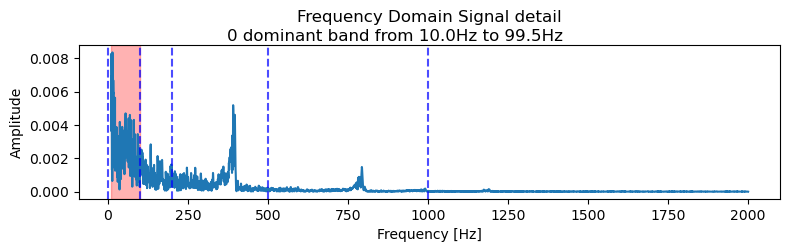

motor to start: 1
   motor  signal    time_start    i
0      1       1  1.725212e+09  1.0
1      2       0  1.725212e+09  NaN
2      3       0  1.725212e+09  NaN
3      4       0  1.725212e+09  NaN
4      5       0  1.725212e+09  NaN
5      6       0  1.725212e+09  NaN
Connected to LOGO!8
1
Recording...
Recording finished.
Amplitude : 0.13337486395666726


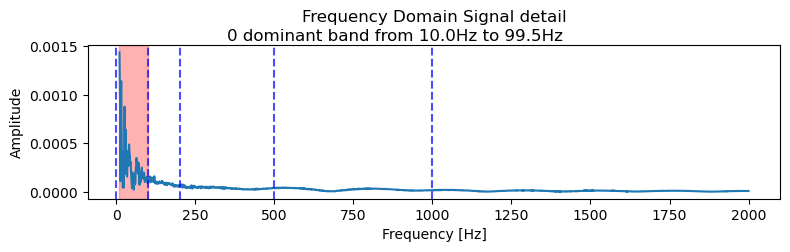

motor to start: 1
   motor  signal    time_start    i
0      1       1  1.725212e+09  2.0
1      2       0  1.725212e+09  NaN
2      3       0  1.725212e+09  NaN
3      4       0  1.725212e+09  NaN
4      5       0  1.725212e+09  NaN
5      6       0  1.725212e+09  NaN
Connected to LOGO!8
2
Recording...
Recording finished.
Mikrofonsignal nicht laut genug, lauter!
Amplitude : 0.00754110256617535
motor to start: 0
   motor  signal    time_start    i
0      0       1  1.725212e+09  3.0
1      1       1  1.725212e+09  2.0
2      2       0  1.725212e+09  NaN
3      3       0  1.725212e+09  NaN
4      4       0  1.725212e+09  NaN
5      5       0  1.725212e+09  NaN
6      6       0  1.725212e+09  NaN
Connected to LOGO!8
3
Recording...
Recording finished.
Mikrofonsignal nicht laut genug, lauter!
Amplitude : 0.0037516098041021494
motor to start: 0
   motor  signal    time_start    i
0      0       1  1.725212e+09  4.0
1      1       0  1.725212e+09  2.0
2      2       0  1.725212e+09  NaN
3   

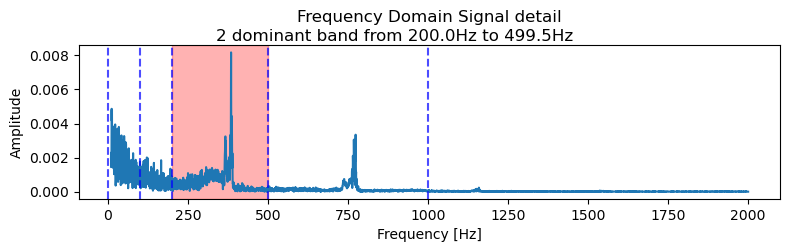

motor to start: 3
   motor  signal    time_start    i
0      0       1  1.725212e+09  4.0
1      1       0  1.725212e+09  2.0
2      2       0  1.725212e+09  NaN
3      3       1  1.725212e+09  5.0
4      4       0  1.725212e+09  NaN
5      5       0  1.725212e+09  NaN
6      6       0  1.725212e+09  NaN
Connected to LOGO!8
5
Recording...
Recording finished.
Mikrofonsignal nicht laut genug, lauter!
Amplitude : 0.08684525537712423
motor to start: 0
   motor  signal    time_start    i
0      0       1  1.725212e+09  6.0
1      1       0  1.725212e+09  2.0
2      2       0  1.725212e+09  NaN
3      3       1  1.725212e+09  5.0
4      4       0  1.725212e+09  NaN
5      5       0  1.725212e+09  NaN
6      6       0  1.725212e+09  NaN
Connected to LOGO!8
6
Recording...
Recording finished.
Mikrofonsignal nicht laut genug, lauter!
Amplitude : 0.010121850896909744
motor to start: 0
   motor  signal    time_start    i
0      0       1  1.725212e+09  7.0
1      1       0  1.725212e+09  2.0
2    

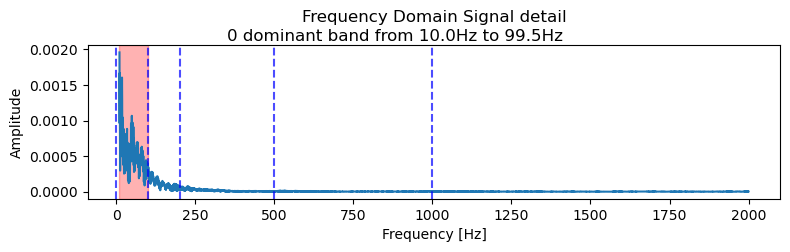

motor to start: 1
   motor  signal    time_start     i
0      0       1  1.725212e+09  10.0
1      1       1  1.725212e+09  11.0
2      2       0  1.725212e+09   NaN
3      3       0  1.725212e+09   5.0
4      4       0  1.725212e+09   NaN
5      5       0  1.725212e+09   NaN
6      6       0  1.725212e+09   NaN
Connected to LOGO!8
11
Recording...
Recording finished.
Mikrofonsignal nicht laut genug, lauter!
Amplitude : 0.06482970420978998
motor to start: 0
   motor  signal    time_start     i
0      0       1  1.725212e+09  12.0
1      1       1  1.725212e+09  11.0
2      2       0  1.725212e+09   NaN
3      3       0  1.725212e+09   5.0
4      4       0  1.725212e+09   NaN
5      5       0  1.725212e+09   NaN
6      6       0  1.725212e+09   NaN
Connected to LOGO!8
12
Recording...
Recording finished.
Mikrofonsignal nicht laut genug, lauter!
Amplitude : 0.04971500473393326
motor to start: 0
   motor  signal    time_start     i
0      0       1  1.725212e+09  13.0
1      1       0  1.72

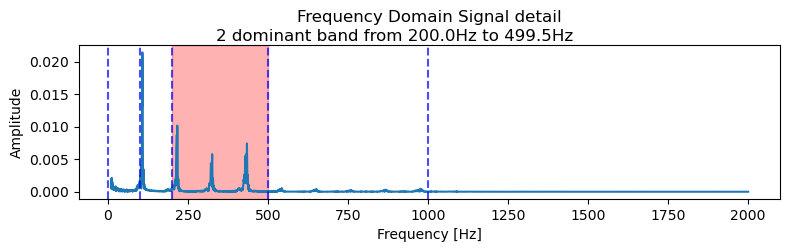

motor to start: 3
   motor  signal    time_start     i
0      0       1  1.725212e+09  16.0
1      1       0  1.725212e+09  11.0
2      2       0  1.725212e+09   NaN
3      3       1  1.725212e+09  17.0
4      4       0  1.725212e+09   NaN
5      5       0  1.725212e+09   NaN
6      6       0  1.725212e+09   NaN
Connected to LOGO!8
17
Recording...
Recording finished.
Amplitude : 0.17762581883892786


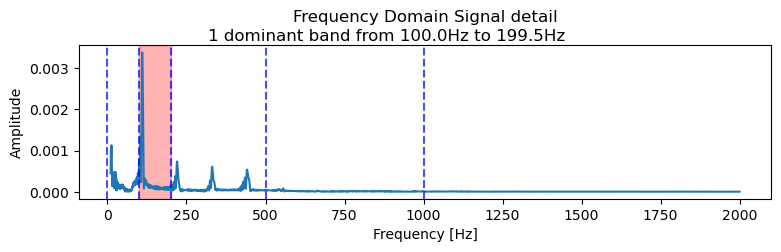

motor to start: 2
   motor  signal    time_start     i
0      0       0  1.725212e+09  16.0
1      1       0  1.725212e+09  11.0
2      2       1  1.725212e+09  18.0
3      3       1  1.725212e+09  17.0
4      4       0  1.725212e+09   NaN
5      5       0  1.725212e+09   NaN
6      6       0  1.725212e+09   NaN
Connected to LOGO!8
18
Recording...
Recording finished.
Amplitude : 0.41663744536316066


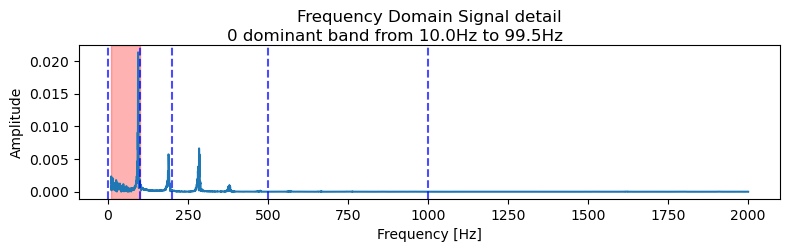

motor to start: 1
   motor  signal    time_start     i
0      0       0  1.725212e+09  16.0
1      1       1  1.725212e+09  19.0
2      2       1  1.725212e+09  18.0
3      3       0  1.725212e+09  17.0
4      4       0  1.725212e+09   NaN
5      5       0  1.725212e+09   NaN
6      6       0  1.725212e+09   NaN
Connected to LOGO!8
19
Recording...
Recording finished.
Amplitude : 0.6748343641504286


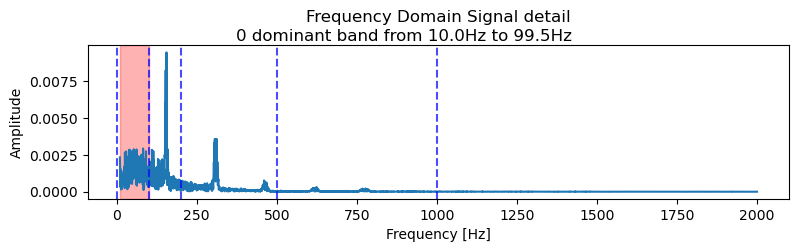

motor to start: 1
   motor  signal    time_start     i
0      0       0  1.725212e+09  16.0
1      1       1  1.725212e+09  20.0
2      2       0  1.725212e+09  18.0
3      3       0  1.725212e+09  17.0
4      4       0  1.725212e+09   NaN
5      5       0  1.725212e+09   NaN
6      6       0  1.725212e+09   NaN
Connected to LOGO!8
20
Recording...
Recording finished.
Amplitude : 0.5495464519781802


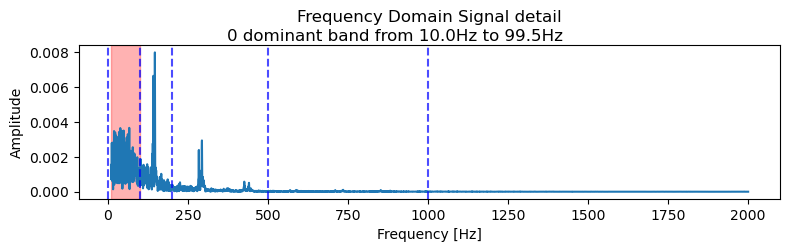

motor to start: 1
   motor  signal    time_start     i
0      0       0  1.725212e+09  16.0
1      1       1  1.725212e+09  21.0
2      2       0  1.725212e+09  18.0
3      3       0  1.725212e+09  17.0
4      4       0  1.725212e+09   NaN
5      5       0  1.725212e+09   NaN
6      6       0  1.725212e+09   NaN
Connected to LOGO!8
21
Recording...
Recording finished.
Amplitude : 1.0811902089299945


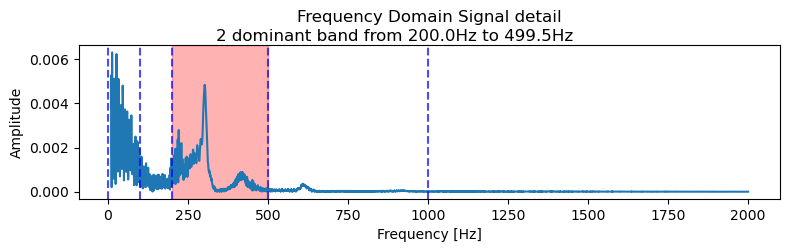

motor to start: 3
   motor  signal    time_start     i
0      0       0  1.725212e+09  16.0
1      1       1  1.725212e+09  21.0
2      2       0  1.725212e+09  18.0
3      3       1  1.725212e+09  22.0
4      4       0  1.725212e+09   NaN
5      5       0  1.725212e+09   NaN
6      6       0  1.725212e+09   NaN
Connected to LOGO!8
22
Recording...
Recording finished.
Mikrofonsignal nicht laut genug, lauter!
Amplitude : 0.05277294179523266
motor to start: 0
   motor  signal    time_start     i
0      0       1  1.725212e+09  23.0
1      1       0  1.725212e+09  21.0
2      2       0  1.725212e+09  18.0
3      3       1  1.725212e+09  22.0
4      4       0  1.725212e+09   NaN
5      5       0  1.725212e+09   NaN
6      6       0  1.725212e+09   NaN
Connected to LOGO!8
23
Recording...
Recording finished.
Mikrofonsignal nicht laut genug, lauter!
Amplitude : 0.019556117750439944
motor to start: 0
   motor  signal    time_start     i
0      0       1  1.725212e+09  24.0
1      1       0  1.7

KeyboardInterrupt: 

In [8]:
def record_and_start_motor(df_motor,  time_recording_s = 2, amplitude_th = 0.1, time_pause_new_recording_s = 1, time_motor_running = 6, 
                           f_min = 10,f_max = 2000, freq_bands=[0, 100, 200, 500, 1000], plot = True):
    """time_motor_running ... how long should each motor run [seconds]
        time_recording_s ...  how long should the recording last
       time_pause_new_recording_s  ... pause until next recording is possible [seconds]
       
       
       parameters for fft:
       amplitude_th = 0.1 
       f_min = 10,f_max = 2000, 
       freq_bands=[0, 100, 200, 500, 1000], plot = True
    """


    import keyboard
    import time

    i = 1
    while True:
        if keyboard.is_pressed('q'):
            return(df_result)
            print("Stopping directory monitoring.")
            break

        # record data for time_recording_S seconds
        audio_signal = record_signal(duration=time_recording_s)

        ##fft analysis

        motor_start = motor_nr_from_signal_dominant_band(audio_signal, amplitude_th= amplitude_th, f_min = f_min, f_max = f_max, freq_bands= freq_bands, plot= plot)
        
        print('motor to start: ' + str(motor_start))

        # =============   update the df_motor dataframe ===================
        df_motor_part = pd.DataFrame({'motor': [motor_start],
                                      'signal':[1]})
        df_motor_part['time_start'] = time.time()
        df_motor_part['i'] = i

        #print(df_motor_part)
        df_motor = pd.concat([df_motor,df_motor_part])
        


        #================  check if a motor should be stopped ==================
        #get the latest data from each motor:
        df_motor_actual = get_motor_time(df_motor)


        #set the signal value to 0 for the motors which shouldn't be running any more
        df_motor.loc[(df_motor['motor'].isin(df_motor_actual['motor'])) &
                     (df_motor['time_start'] + time_motor_running < time.time()), 'signal'] = 0
        
        df_motor_actual_for_logo = get_motor_time(df_motor)
        # set output logo:
        print(df_motor_actual_for_logo)


        df_motor_actual_for_logo['time_start'] = time.time()
        if i ==1:
            df_result = df_motor_actual_for_logo
        else:
            df_result = pd.concat([df_result, df_motor_actual_for_logo])


        #===================================== write the values to the logo ======================================
        plc = snap7.logo.Logo()

        #IP Server, TSAP Client, TSAP Server
        #IP Adress from the logo = IP Server
        plc.connect("169.254.116.131", 0x3000, 0x2000)

        df_motor_signals = get_motor_time(df_motor)
        write_to_logo(df_motor_signals, plc_connected=plc)


        plc.disconnect()
        plc.destroy()

        #

        time.sleep(time_pause_new_recording_s)
        
        print(i)
        i+=1
        


    #record


df_motor3 = record_and_start_motor(df_motor_init)

<AxesSubplot: xlabel='time_start', ylabel='signal'>

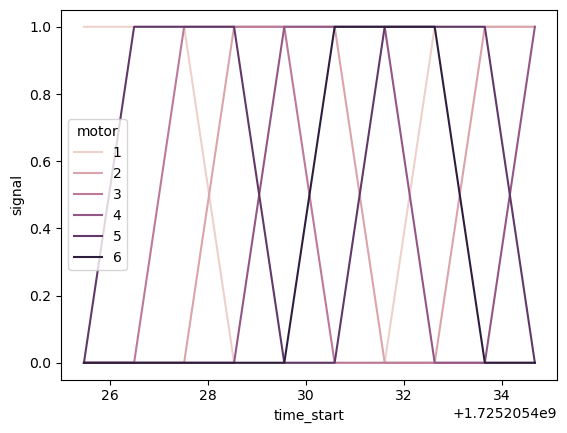

In [26]:
sns.lineplot(df_motor3,x = "time_start", y = 'signal', hue='motor')
#df_motor3

In [50]:


df_actual = get_motor_time(df_motor2)



,motor,signal,time_start,i
0,1,1,1.725184e+09,1
1,2,1,1.725184e+09,4
2,3,1,1.725184e+09,3
3,4,1,1.725184e+09,5
4,5,1,1.725184e+09,2
5,6,1,1.725184e+09,6
